<a href="https://colab.research.google.com/github/SaraZachi/Modelo-Previsao_COVID19/blob/main/An%C3%A1lise_comparativa_modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Introdução**



Coronavírus é uma família de vírus que, a partir de dezembro de 2019, passou a provocar uma doença infeciosa que chamamos de COVID-19 (coronavírus). O vírus é facilmente tranmitido, podendo causar graves infecções respiratórias que podem levar a morte, tornando-o um vírus temido por toda população global.

A fim de determinar a direção de ações futuras contra a pandemia do coronavírus, o presente estudo propõe realizar um modelo de previsões da série temporal do número de casos notificados de COVID-19 no Paraná e Pernambuco.

Entender o comportamento do número de casos notificados e identificar a existência de padrões dentro da série temporal, nos permite, por exemplo, prever a demanda por equipamentos, leitos e profissionais nos órgãos de sáude, permitindo um melhor manejo das medidas públicas necessárias para satisfazer a demanda. Deste modo, quanto mais precisos e próximos da nossa realidade atual forem os resultados do modelo de previsão, essas medidas serão melhor elaboradas e mais vidas poderão ser salvas!

# **2. Presetings**

In [87]:
# Importando Bibliotecas
import pandas as pd
from pandas.plotting import autocorrelation_plot

import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

from sklearn.metrics import mean_absolute_error

In [88]:
# Removendo avisos
import warnings
warnings.filterwarnings('ignore')

#setting charts style
sns.set()

In [89]:
# Importando Dataframe
url = 'https://github.com/marcelobin/BootCamp-Data-Science---Alura/blob/main/Projeto%20-%20M%C3%B3dulo%203%20-%20S%C3%A9ries%20Temporais/dados/caso_full.zip?raw=true'
dados =  pd.read_csv(url, sep = ',', compression='zip')
dados.head()

,city,city_ibge_code,date,epidemiological_week,estimated_population,estimated_population_2019,is_last,is_repeated,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,last_available_date,last_available_death_rate,last_available_deaths,order_for_place,place_type,state,new_confirmed,new_deaths
0,Rio Branco,1200401.0,2020-03-17,202012,413418.0,407319.0,False,False,3,0.72566,2020-03-17,0.0,0,1,city,AC,3,0
1,NaN,12.0,2020-03-17,202012,894470.0,881935.0,False,False,3,0.33539,2020-03-17,0.0,0,1,state,AC,3,0
2,Rio Branco,1200401.0,2020-03-18,202012,413418.0,407319.0,False,False,3,0.72566,2020-03-18,0.0,0,2,city,AC,0,0
3,NaN,12.0,2020-03-18,202012,894470.0,881935.0,False,False,3,0.33539,2020-03-18,0.0,0,2,state,AC,0,0
4,Rio Branco,1200401.0,2020-03-19,202012,413418.0,407319.0,False,False,4,0.96754,2020-03-19,0.0,0,3,city,AC,1,0


* Fonte: Secretarias de Saúde das Unidades Federativas, dados tratados por Álvaro Justen e equipe de voluntários [Brasil.IO](https://brasil.io/home/)
* Brasil.IO: boletins epidemiológicos da COVID-19 por município por dia, disponível em: https://brasil.io/dataset/covid19/caso_full/ (última atualização: 16 de Julho de 2021, acesso em 16 de Julho de 2021).

In [90]:
# Formatando a coluna 'date' para o formato: '%Y-%m-%d' == 'year-months-days'
dados['date'] = pd.to_datetime(dados['date'], format='%Y-%m-%d')

In [91]:
# Data frame de PA
df_pa = dados.query('state == "PA"')

# Df da soma dos dados por dia de PE
df_pa_sum = df_pa.groupby(['date']).sum()
df_pa_sum = df_pa_sum.reset_index()

# Adição das colunas ano, mês e dia
df_pa_sum['year'] = pd.DatetimeIndex(df_pa_sum['date']).year
df_pa_sum['month'] = pd.DatetimeIndex(df_pa_sum['date']).month
df_pa_sum['day'] = pd.DatetimeIndex(df_pa_sum['date']).day

df_pa_sum.head()

,date,city_ibge_code,epidemiological_week,estimated_population,estimated_population_2019,is_last,is_repeated,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,last_available_death_rate,last_available_deaths,order_for_place,new_confirmed,new_deaths,year,month,day
0,2020-03-18,1501417.0,404024,10190386.0,10095610.0,0,0,2,0.07819,0.0,0,2,2,0,2020,3,18
1,2020-03-19,1501417.0,404024,10190386.0,10095610.0,0,0,2,0.07819,0.0,0,4,0,0,2020,3,19
2,2020-03-20,1501417.0,404024,10190386.0,10095610.0,0,0,4,0.15638,0.0,0,6,2,0,2020,3,20
3,2020-03-21,1501417.0,404024,10190386.0,10095610.0,0,0,4,0.15638,0.0,0,8,0,0,2020,3,21
4,2020-03-22,1501417.0,404026,10190386.0,10095610.0,0,0,8,0.31276,0.0,0,10,4,0,2020,3,22


In [92]:
# Data frame de PE
df_pe = dados.query('state == "PE"')

# Df da soma dos dados por dia de PE
df_pe_sum = df_pe.groupby(['date']).sum()
df_pe_sum = df_pe_sum.reset_index()

# Adição das colunas ano, mês e dia
df_pe_sum['year'] = pd.DatetimeIndex(df_pe_sum['date']).year
df_pe_sum['month'] = pd.DatetimeIndex(df_pe_sum['date']).month
df_pe_sum['day'] = pd.DatetimeIndex(df_pe_sum['date']).day

df_pe_sum.head()

,date,city_ibge_code,epidemiological_week,estimated_population,estimated_population_2019,is_last,is_repeated,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,last_available_death_rate,last_available_deaths,order_for_place,new_confirmed,new_deaths,year,month,day
0,2020-03-12,2611632.0,404022,11270082.0,11202798.0,0,0,4,0.14176,0.0,0,2,4,0,2020,3,12
1,2020-03-13,2611632.0,404022,11270082.0,11202798.0,0,0,4,0.14176,0.0,0,4,0,0,2020,3,13
2,2020-03-14,2611632.0,606033,11270082.0,11202798.0,0,0,14,0.43567,0.0,0,7,10,0,2020,3,14
3,2020-03-15,2611632.0,606036,11270082.0,11202798.0,0,0,16,0.50654,0.0,0,10,2,0,2020,3,15
4,2020-03-16,2611632.0,606036,11270082.0,11202798.0,0,2,16,0.50654,0.0,0,13,0,0,2020,3,16


# **3. Comparações prévias** 

Vamos iniciar comparando a média móvel do número de casos recentes de ambos os estados. A média móvel de casos notificados em um determinado período (ex.: 7 dias) pode ser comparada com as médias das semanas anteriores. Assim, podemos observar se esse número está aumentando, estabilizando ou diminuindo:

In [93]:
# Determinando a média movel (mm) do PA e PE
df_pa_sum['mm_casos_pa'] = df_pa_sum['new_confirmed'].rolling(window=7, center=False).mean()
df_pe_sum['mm_casos_pe'] = df_pe_sum['new_confirmed'].rolling(window=7, center=False).mean()

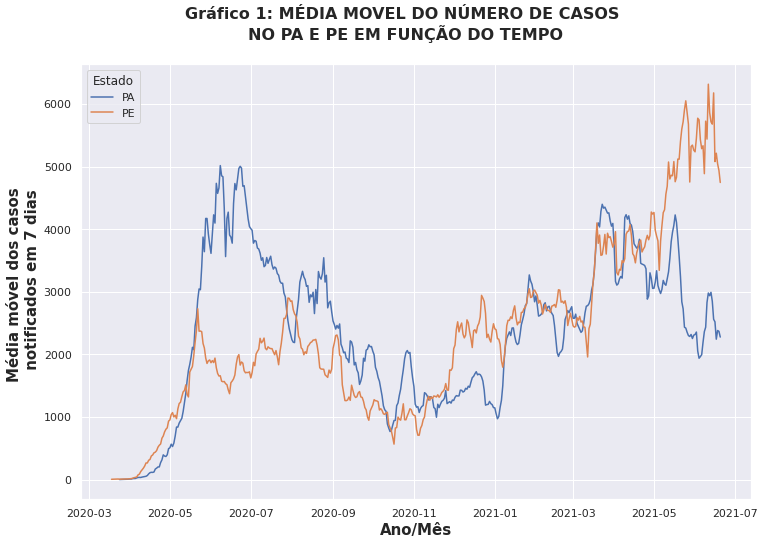

In [94]:
# Plot da média movel do PA e PE
sns.lineplot(x='date', y='mm_casos_pa', data=df_pa_sum, label = 'PA')
sns.lineplot(x='date', y='mm_casos_pe', data=df_pe_sum, label = 'PE')

# Title and labels
plt.legend(title='Estado')
plt.suptitle("Gráfico 1: MÉDIA MOVEL DO NÚMERO DE CASOS \nNO PA E PE EM FUNÇÃO DO TEMPO", 
             fontsize=16, fontweight='bold')
plt.xlabel('Ano/Mês', fontsize = 15, fontweight = 'bold')
plt.ylabel('Média móvel dos casos \n notificados em 7 dias', fontsize = 15, fontweight = 'bold')

plt.show()

Como podemos ver acima, há dois picos do número de casos de ambos os estados. Acima podemos ver que a segunda onda iniciou após dezembro de 2021 em ambos os estados, talvez devido as festas de fim de ano e ao relaxamento da população em tomar as devidas precauções para evitar o contágio. Além disso, estudos também buscam demostar que a nova variante do Coronavírus pode ser responsável pela rápida disseminação da doença no mundo [[1](https://www.sanarmed.com/nova-variante-coronavirus)]. 
No gráfico 1 também é possível identificar que o número de casos está diminuindo no Paraná, enquanto que em Pernambuco está aumentando.

# **4. Modelos de previsão**

Os modelos de previsão do PA e PE foram formulados e avaliados nos respectivos notbooks: [02 Modelo de validação PA](https://colab.research.google.com/drive/1nCvlGqpLby4UCtsbS4ML2S7Ghs8W6RMD#scrollTo=FLqL1_13CAwX) e [03 Modelo de validação PE](https://colab.research.google.com/drive/11qfHj01NmVJPYrwO1bQkBLAX9WMzoCnA#scrollTo=GhNQIjXgXaYf). Para fins de avalização entre os medelos de cada estao, apenas o modelo final, incluindo os parâmetros de input, de ambos será importado.

### **Dataframe dos dados de treino**

In [95]:
# Dataframe dos dados de treino do PA
df_pa_treino = pd.DataFrame()
df_pa_treino['ds'] = df_pa_sum['date'][:409]
df_pa_treino['y'] = df_pa_sum['new_confirmed'][:409]
df_pa_treino.tail()

,ds,y
404,2021-04-26,2184
405,2021-04-27,5652
406,2021-04-28,5260
407,2021-04-29,4070
408,2021-04-30,2854


In [96]:
# Dataframe dos dados de treino de PE
df_pe_treino = pd.DataFrame()
df_pe_treino['ds'] = df_pe_sum['date'][:409]
df_pe_treino['y'] = df_pe_sum['new_confirmed'][:409]
df_pe_treino.tail()

,ds,y
404,2021-04-20,5686
405,2021-04-21,4960
406,2021-04-22,2404
407,2021-04-23,4062
408,2021-04-24,4178


### **Dataframe dos dados de teste**

In [97]:
# Dataframe dos dados de teste do PA
df_pa_teste = pd.DataFrame()
df_pa_teste['ds'] = df_pa_sum['date'][409:]
df_pa_teste['y'] = df_pa_sum['new_confirmed'][409:]
df_pa_teste.head()

,ds,y
409,2021-05-01,1106
410,2021-05-02,958
411,2021-05-03,3452
412,2021-05-04,3998
413,2021-05-05,4772


In [98]:
# Dataframe dos dados de teste de PE
df_pe_teste = pd.DataFrame()
df_pe_teste['ds'] = df_pe_sum['date'][409:]
df_pe_teste['y'] = df_pe_sum['new_confirmed'][409:]
df_pe_teste.head()

,ds,y
409,2021-04-25,3468
410,2021-04-26,2556
411,2021-04-27,5192
412,2021-04-28,5440
413,2021-04-29,5022


### **Adicionando os feriados dos dois estados**

Criamos um string dos feriados anuais do estado do PA e PE apenas com dadats dos meses registrados no banco de dados de treino (março de 2020 a abril 2021). Os feriados aqui informados foram extráidos do site: www.feriados.com.br

In [99]:
# Feriados do PA de 2020
feriados_pa_2020= [
'2020-04-01',
'2020-04-10',
'2020-04-12',
'2020-04-21',
'2020-05-01',
'2020-05-10',
'2020-06-11',
'2020-06-12',
'2020-08-09',
'2020-08-15',
'2020-09-07',
'2020-10-12',
'2020-10-15',
'2020-10-17',
'2020-10-28',
'2020-11-02',
'2020-11-15',
'2020-11-20',
'2020-12-25'
]

# Feriados do PA de 2021
feriados_pa_2021= [
'2021-01-01',
'2021-02-15',
'2021-02-16',
'2021-02-17',
'2021-04-01',
'2021-04-02',
'2021-04-04',
'2021-04-21'
]

In [100]:
# Feriados do PE de 2020
feriados_pe_2020= [
'2020-04-01',
'2020-04-10',
'2020-04-12',
'2020-04-21',
'2020-05-01',
'2020-05-10',
'2020-06-11',
'2020-06-12',
'2020-06-24',
'2020-08-09',
'2020-09-07',
'2020-10-12',
'2020-10-15',
'2020-10-17',
'2020-10-28',
'2020-11-02',
'2020-11-15',
'2020-11-20',
'2020-12-25'
]

# Feriados do PE de 2021
feriados_pe_2021= [
'2021-01-01',
'2021-02-15',
'2021-02-16',
'2021-02-17',
'2021-03-06',
'2021-04-01',
'2021-04-02',
'2021-04-04',
'2021-04-21'
]

### **Dataframe dos feriados**

In [101]:
# Criando df dos feriados do PA em 2020
feriados_pa_2020 = pd.DataFrame({'holiday': 'pa_2020', 
                                 'ds': pd.to_datetime(feriados_pa_2020)})
# Criando df dos feriados do PA em 2021
feriados_pa_2021 = pd.DataFrame({'holiday': 'pa_2021', 
                                 'ds': pd.to_datetime(feriados_pa_2021)})

# Concatenando os dfs dos feriados de 2020 e 2021
feriados_pa = pd.concat((feriados_pa_2020, feriados_pa_2021))

In [102]:
# Criando df dos feriados do PE em 2020
feriados_pe_2020 = pd.DataFrame({'holiday': 'pe_2020', 
                                 'ds': pd.to_datetime(feriados_pe_2020)})
# Criando df dos feriados do PE em 2021
feriados_pe_2021 = pd.DataFrame({'holiday': 'pe_2021', 
                                 'ds': pd.to_datetime(feriados_pe_2021)})

# Concatenando os dfs dos feriados de 2020 e 2021
feriados_pe = pd.concat((feriados_pe_2020, feriados_pe_2021))

### **Modelos para previsão com outliers**

In [103]:
# Modelo dos dados de treino, com os feriados do PA
modelo_feriados_pa = Prophet(changepoint_prior_scale=10.0, holidays=feriados_pa, seasonality_mode='multiplicative')
modelo_feriados_pa.fit(df_pa_treino)

# Dataframe de previsão dos dados de treino
dataframefuturo_pa = modelo_feriados_pa.make_future_dataframe(periods=43)
previsao_pa = modelo_feriados_pa.predict(dataframefuturo_pa)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [104]:
# Modelo dos dados de treino, com os feriados do PE
modelo_feriados_pe = Prophet(changepoint_prior_scale=10.0, holidays=feriados_pe, seasonality_mode='multiplicative')
modelo_feriados_pe.fit(df_pe_treino)

# Dataframe de previsão dos dados de treino
dataframefuturo_pe = modelo_feriados_pe.make_future_dataframe(periods=43)
previsao_pe = modelo_feriados_pe.predict(dataframefuturo_pe)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### **Removendo os outliers do dataframe de treino**

In [105]:
# Add index em df do PA
novo_y_pa = df_pa_treino.reset_index()

# Removendo outliers do dataframe de previsao do PA
sem_outliers_pa = novo_y_pa[(novo_y_pa['y']> previsao_pa['yhat_lower'][:409]) & (novo_y_pa['y'] < previsao_pa['yhat_upper'][:409])]

# Novo df sem outliers do PA
df_sem_outliers_pa = sem_outliers_pa[['ds','y']]
df_sem_outliers_pa.head()

,ds,y
0,2020-03-18,2
1,2020-03-19,0
2,2020-03-20,2
3,2020-03-21,0
4,2020-03-22,4


In [106]:
# Add index em df do PE
novo_y_pe = df_pe_treino.reset_index()

# Removendo outliers do dataframe de previsao do PE
sem_outliers_pe = novo_y_pe[(novo_y_pe['y']> previsao_pe['yhat_lower'][:409]) & (novo_y_pe['y'] < previsao_pe['yhat_upper'][:409])]

# Novo df sem outliers do PE
df_sem_outliers_pe = sem_outliers_pe[['ds','y']]
df_sem_outliers_pe.head()

,ds,y
0,2020-03-12,4
1,2020-03-13,0
2,2020-03-14,10
3,2020-03-15,2
4,2020-03-16,0


### **Modelos para previsão sem outliers**

In [107]:
# Modelo dos dados de treino, com os feriados do PA
modelo_feriados_pa = Prophet(changepoint_prior_scale=10.0, holidays=feriados_pa, seasonality_mode='multiplicative')
modelo_feriados_pa.fit(df_sem_outliers_pa)

# Dataframe de previsão dos dados de treino
dataframefuturo_pa = modelo_feriados_pa.make_future_dataframe(periods=43)
previsao_pa = modelo_feriados_pa.predict(dataframefuturo_pa)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [108]:
# Modelo dos dados de treino, com os feriados do PE
modelo_feriados_pe = Prophet(changepoint_prior_scale=10.0, holidays=feriados_pe, seasonality_mode='multiplicative')
modelo_feriados_pe.fit(df_sem_outliers_pe)

# Dataframe de previsão dos dados de treino
dataframefuturo_pe = modelo_feriados_pe.make_future_dataframe(periods=43)
previsao_pe = modelo_feriados_pe.predict(dataframefuturo_pe)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### **Gráficos de previsão**

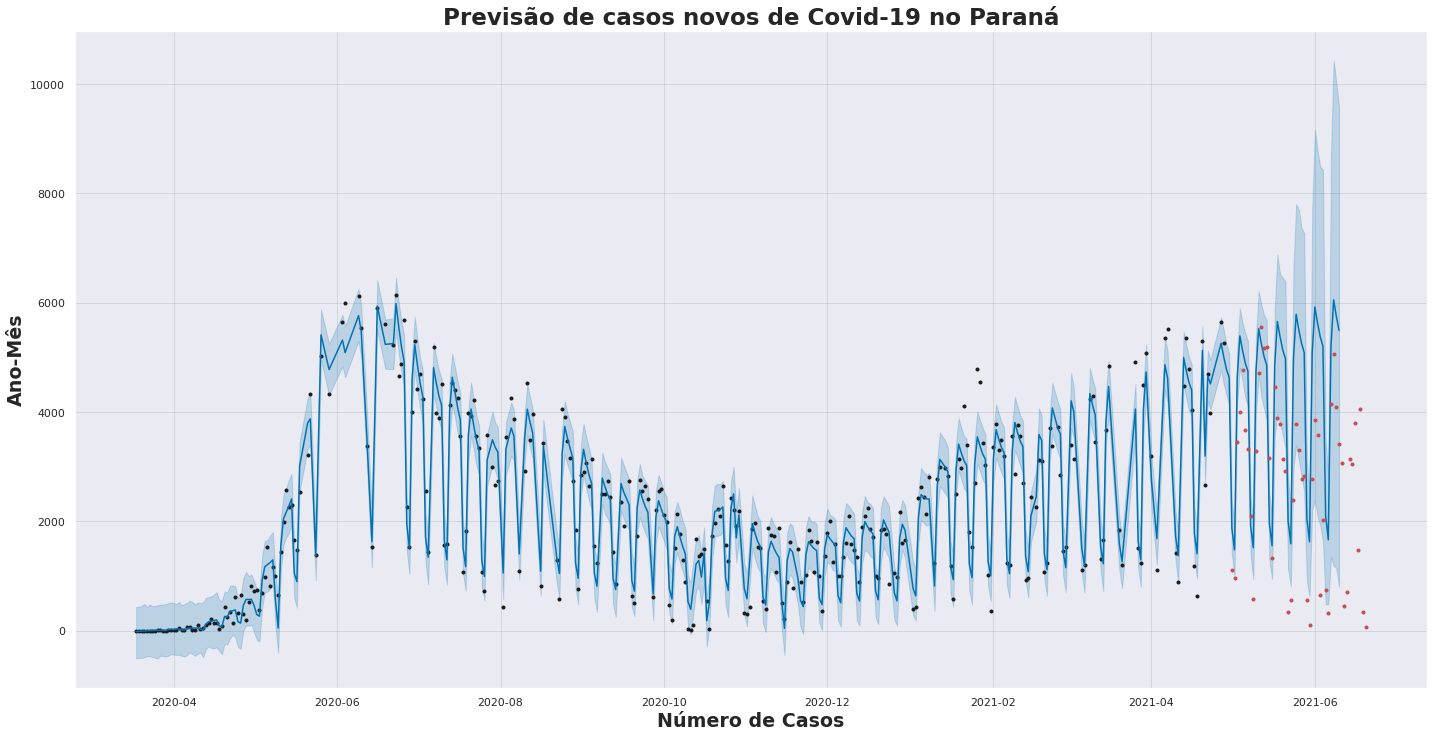

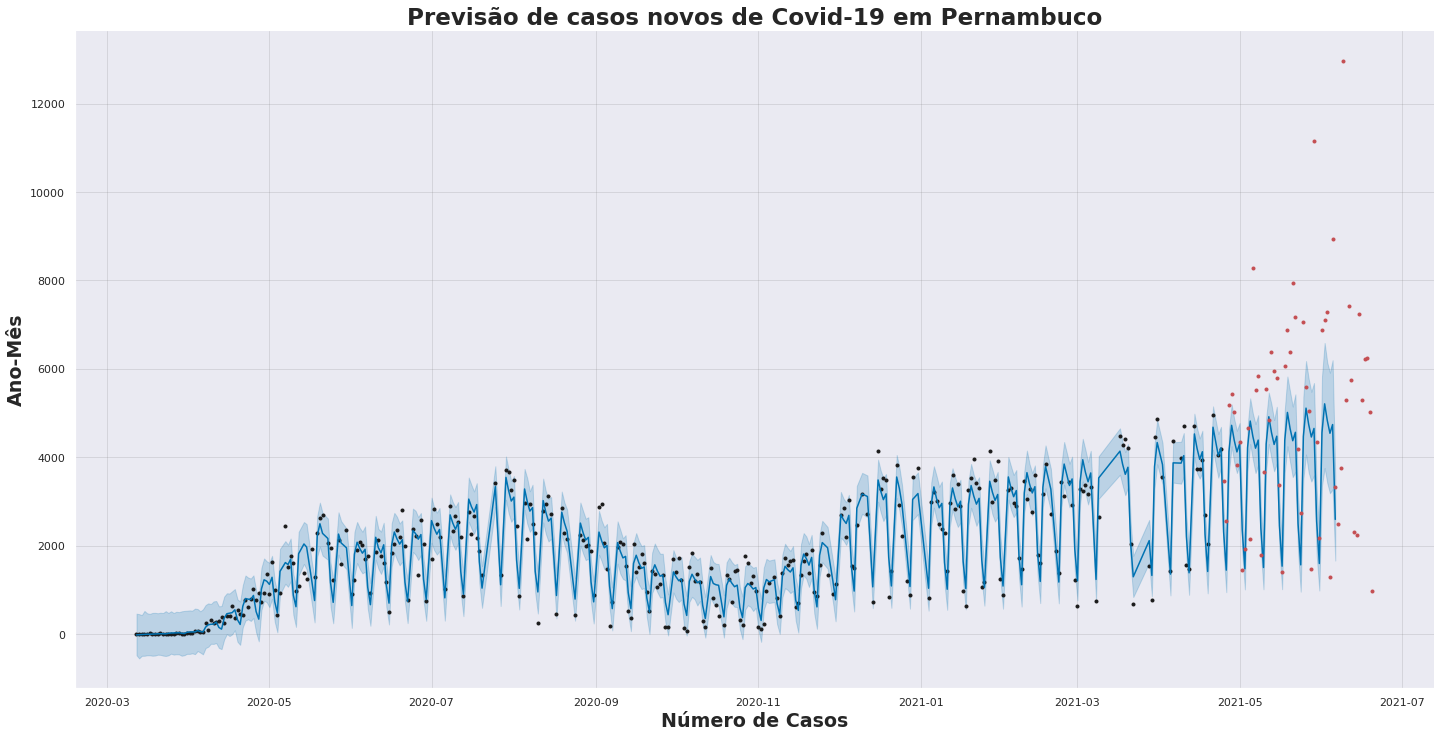

In [109]:
# Gráfico da previsão do PA
fig_pa = modelo_feriados_pa.plot(previsao_pa, figsize=(20,10));
plt.plot(df_pa_teste['ds'], df_pa_teste['y'], '.r')
plt.title('Previsão de casos novos de Covid-19 no Paraná', loc = 'center', fontsize = 23, fontweight = 'bold')
plt.ylabel('Ano-Mês', fontsize = 19, fontweight = 'bold')
plt.xlabel('Número de Casos', fontsize = 19, fontweight = 'bold')

# Gráfico da previsão de PE
fig_pe = modelo_feriados_pe.plot(previsao_pe, figsize=(20,10));
plt.plot(df_pe_teste['ds'], df_pe_teste['y'], '.r')
plt.title('Previsão de casos novos de Covid-19 em Pernambuco', loc = 'center', fontsize = 23, fontweight = 'bold')
plt.ylabel('Ano-Mês', fontsize = 19, fontweight = 'bold')
plt.xlabel('Número de Casos', fontsize = 19, fontweight = 'bold')

sns.despine()
plt.show()

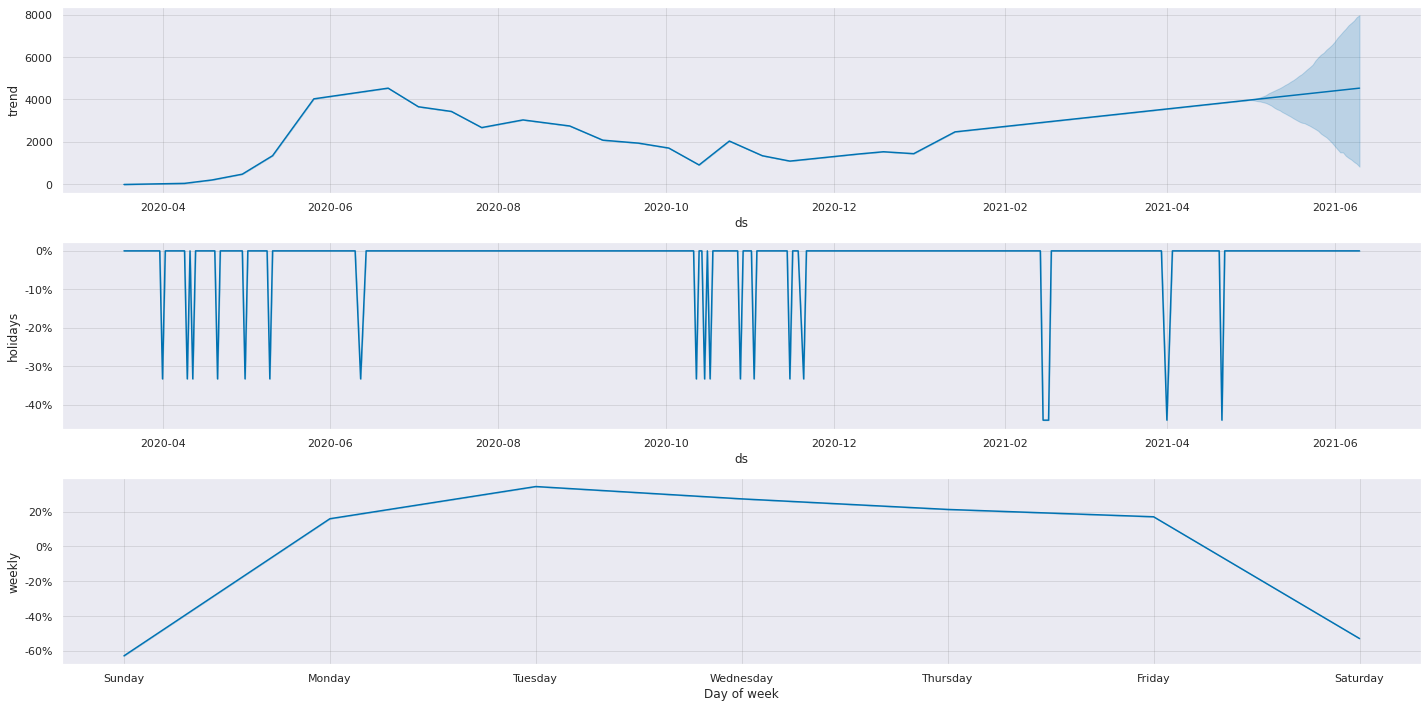

In [110]:
# Componentes do modelo de previsão do PA
modelo_feriados_pa.plot_components(previsao_pa, figsize=(20,10));

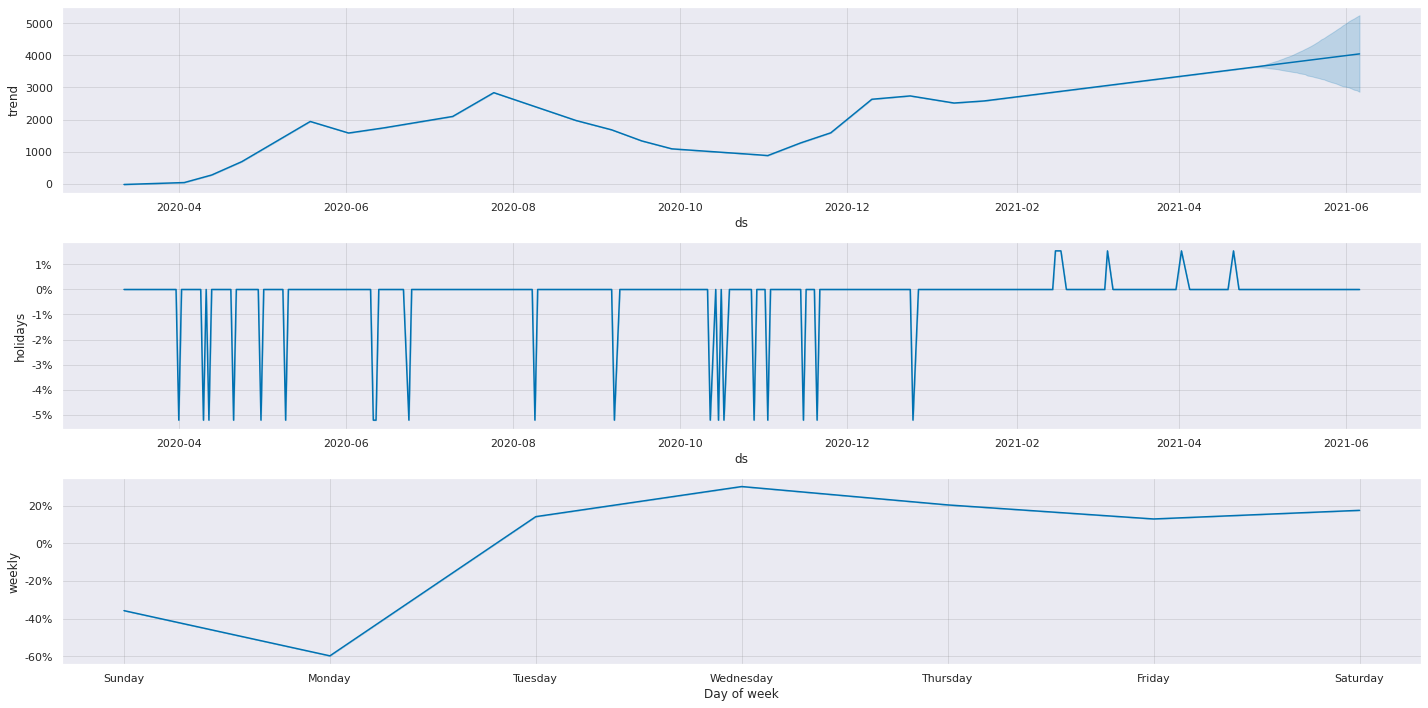

In [111]:
# Componentes do modelo de previsão de PE
modelo_feriados_pe.plot_components(previsao_pe, figsize=(20,10));

# **5. Conclusões**

Como podemos ver acima, nos dois modelos há uma queda na notificação do número de casos aos feriados até fevereiro de 2021. A partir deste mês o número de casos notificados em Pernambuco aos feriados sobe ao invés de cair, como continua ocorrendo no Paraná. Adicionalmente, o número de casos notificados em PE cai aos domingos e segundas, enquanto que no PA cai aos sábados e domingos.

Os modelos acima nos mostram a importância de adicionar outras constantes ao modelo de previsão além das informações no banco de dados, como fizemos ao adicionar as datas dos feriádos de cada mês. Por mais que a acurácia dessa previsão tenha sido boa, é importante ralizar outros modelos, adicionando outras constantes, verificando seus efeitos ao modelo de previsão.

Por exemplo, para compreendermos melhor as diferênças entre os dois modelos, seria interessante realizar o mesmo modelo por cidade de cada um dos estados, adicionando informações dos horários e datas de atendimento dos hospitais regionais.

# **6. Projetos futuros propostos**

* Realizar novas costumizações aos inputs do modelo de previsão com outros parâmetros para identificarmos qual trará uma aderência melhor do medelo de previsão ao banco de dados.
* Comparar os resultados com outros dados, por exemplo: número de pessoas vacinadas; número de pessoas nas ruas aos feriados, finais de semana e dias de semana; dentre outras informações que possam auxiliar na confiabilidade do modelo.
* Realizar o mesmo modelo por cidade de cada um dos estados, comparando os resultados às informações de atendimento dos hospitais da região.
* Reproduzir o modelo de previsão para o número de óbitos.

# **Referências**

1. https://www.linkedin.com/pulse/ado%C3%A7%C3%A3o-de-animais-com-s%C3%A9ries-temporais-prophet-saulo-maia?articleId=6670299069421780992
2. https://medium.com/data-hackers/que-tal-pedir-ajuda-do-profeta-926924c26508
3. https://github.com/facebook/prophet
4. https://www.ibpad.com.br/blog/analise-de-dados/prophet-vs-forecast-vs-mafs-qual-o-melhor-pacote-para-series-temporais/
5. https://docs.google.com/spreadsheets/d/1S77CvorwQripFZjlWTOZeBhK42rh3u57aRL1XZGhSdI/edit#gid=0
6. https://brasil.io/home/
7. https://coronavirus.saude.mg.gov.br/


# **Notebooks de apoio**

1. https://github.com/SaraZachi/Modelo-Previsao_COVID19/blob/main/Notebooks/01_Primeiras_an%C3%A1lises.ipynb
2. https://github.com/SaraZachi/Modelo-Previsao_COVID19/blob/main/Notebooks/02_Modelo_de_valida%C3%A7%C3%A3o_PA.ipynb
3. https://github.com/SaraZachi/Modelo-Previsao_COVID19/blob/main/Notebooks/03_Modelo_de_valida%C3%A7%C3%A3o_PE.ipynb